# imports

In [1]:
import pandas as pd
import numpy as np
import sklearn
import pickle 
import time 
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
%run ../function_proposed_gcn.py

In [3]:
with open('../fraudTrain.pkl', 'rb') as file:
    fraudTrain = pickle.load(file)    

In [4]:
df50 = throw(fraudTrain,0.5)
df_tr, df_tst = sklearn.model_selection.train_test_split(df50)

dfn = fraudTrain[::10]

In [10]:
dfnn = dfn[~dfn.index.isin(df_tr.index)]

In [11]:
dfnn.is_fraud.mean()

0.0014052108297481207

In [12]:
dfnn = dfnn.reset_index(drop=True)

In [13]:
df_trn, df_tstn = sklearn.model_selection.train_test_split(dfnn)

In [15]:
df_tr.shape,df_tstn.shape

((9009, 22), (25975, 22))

In [16]:
df2, mask = concat(df_tr, df_tstn)
df2['index'] = df2.index
df = df2.reset_index()

In [17]:
df.is_fraud.mean(), df_tr.is_fraud.mean(), df_tstn.is_fraud.mean()

(0.1296878573061971, 0.4997224997224997, 0.001347449470644851)

In [18]:
groups = df.groupby('cc_num')

In [19]:
edge_index = np.array([item for sublist in (compute_time_difference(group) for _, group in groups) for item in sublist])
edge_index = edge_index.astype(np.float64)

In [20]:
edge_index[:,2].mean()

11358175.07907386

(array([396764., 293830., 253646., 219982., 184930., 141202., 106036.,
         71386.,  31362.,  10150.]),
 array([       0.,  3750282.,  7500564., 11250846., 15001128., 18751410.,
        22501692., 26251974., 30002256., 33752538., 37502820.]),
 <BarContainer object of 10 artists>)

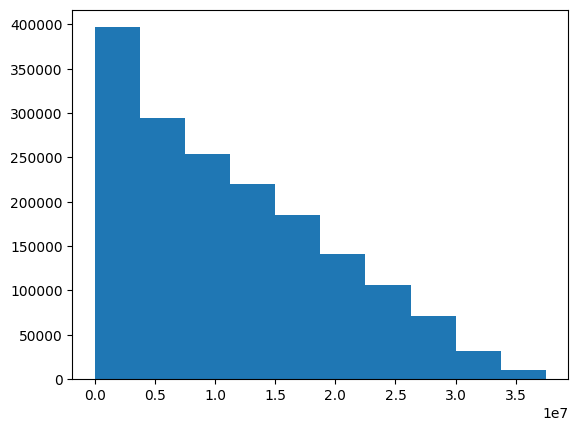

In [21]:
plt.hist(edge_index[:,2])

In [22]:
theta = edge_index[:,2].mean()

In [23]:
edge_index[:,2] = (np.exp(-edge_index[:,2]/(theta)) != 1)*(np.exp(-edge_index[:,2]/(theta))).tolist()

In [24]:
gamma = 0.8

In [25]:
edge_index = torch.tensor([(int(row[0]), int(row[1])) for row in edge_index if row[2] > gamma], dtype=torch.long).t()

In [26]:
x = torch.tensor(df['amt'].values, dtype=torch.float).reshape(-1,1)
y = torch.tensor(df['is_fraud'].values,dtype=torch.int64)
data = torch_geometric.data.Data(x=x, edge_index = edge_index, y=y, train_mask = mask[0], test_mask= mask[1])


In [27]:
model = GCN1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
yy = (data.y[data.test_mask]).numpy()
yyhat, yyhat_ = train_and_evaluate_model(data, model, optimizer)
yyhat_ = yyhat_.detach().numpy()
eval = evaluation(yy, yyhat, yyhat_)

In [28]:
eval

{'acc': 0.9131857555341675,
 'pre': 0.01486013986013986,
 'rec': 0.9714285714285714,
 'f1': 0.029272492466637965,
 'auc': 0.9741133384734002}